In [49]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

from py_wake.flow_map import Points

from py_wake.wind_turbines._wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake import HorizontalGrid
from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.utils.plotting import setup_plot

In [50]:
D = 150 # Rotor diameter
s = 7 # Turbine spacing
zh = 100 # Hub height
ws = 12 # Wind speed
km_behind = 40 # Downstream measurement distance
x_turb_no = 10 # No. of turbines in streamwise direction
y_turb_no = 7 # No. of turbines in transverse direction

u = np.arange(0, 25.5, .5)
po = [0, 0, 0, 0, 5, 15, 37, 73, 122, 183, 259, 357, 477, 622, 791, 988, 1212, 1469, 1755, 2009, 2176, 2298, 2388, 2447, 2485, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 0]
ct = [0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0]

ct = 0.8 * np.ones_like(ct)

wt1 = WindTurbine(name="Ørsted1", diameter=D, hub_height=zh, powerCtFunction=PowerCtTabular(u, po, 'kw', ct))

u2 = np.arange(0, 27)
pow2 = [0, 0, 0, 0, 54, 144, 289, 474, 730, 1050, 1417, 1780, 2041, 2199, 2260, 2292, 2299, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 0]
ct2  = [0, 0, 0, 0, 0.94, 0.82, 0.76, 0.68, 0.86, 0.83, 0.77, 0.68, 0.66, 0.52, 0.47, 0.41, 0.38, 0.34, 0.27, 0.26, 0.23, 0.22, 0.22, 0.2, 0.16, 0.17, 0]
wt2 = WindTurbine(name="Ørsted2", diameter=80, hub_height=70, powerCtFunction=PowerCtTabular(u2, pow2, 'kw', ct2))
wts = WindTurbines.from_WindTurbine_lst([wt1,wt2])

#py_wake.examples

In [51]:
u = np.linspace(0,25)

'''for t in [0,1]:
    plt.plot(u,wts.power(u, type=t)/1000, label=wts.name(t))
setup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]', title='Power curve')'''

"for t in [0,1]:\n    plt.plot(u,wts.power(u, type=t)/1000, label=wts.name(t))\nsetup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]', title='Power curve')"

In [52]:
'''for t in [0,1]:
    plt.plot(u,wts.ct(u, type=t), label=wts.name(t))
setup_plot(xlabel='Wind speed [m/s]', ylabel='Thrust coefficient [-]', title='Thrust curve')'''

"for t in [0,1]:\n    plt.plot(u,wts.ct(u, type=t), label=wts.name(t))\nsetup_plot(xlabel='Wind speed [m/s]', ylabel='Thrust coefficient [-]', title='Thrust curve')"

In [53]:
u0 = [6, 7, 8, 9, 10, 11, 12, 13, 14] # [m/s]
u0 = 10
wd = 270 # [deg]
ti0 = [0.09, 0.1, 0.11, 0.12, 0.14, 0.15, 0.16, 0.17, 0.18] # [-]
ti0 = np.mean(ti0)

y, x = [v.flatten() for v in np.meshgrid(np.arange(y_turb_no) * D * s, np.arange(x_turb_no) * D * s)]
#wt1.plot(x, y)

In [54]:
site = UniformSite(shear=PowerShear(h_ref=zh, alpha=.1))
wfm = PropagateDownwind(site, wt1, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True), superpositionModel=LinearSum())
sim = wfm(x, y, ws=ws, wd=wd, TI=ti0)

In [55]:
'''((1-(sim.Power.mean('wt') / sim.Power.max('wt')))*100).plot()
setup_plot(ylabel='Wake loss [%]', xlabel='Freestream wind speed [m/s]')'''

"((1-(sim.Power.mean('wt') / sim.Power.max('wt')))*100).plot()\nsetup_plot(ylabel='Wake loss [%]', xlabel='Freestream wind speed [m/s]')"

In [56]:
x_meas = max(x) + km_behind*1000 # Measurement dist. after farm

w_meas = 10000 # Measurement width after farm

y_meas = np.linspace(min(y)-w_meas, max(y)+w_meas, max(y)+2*w_meas, endpoint=False) # y-values at x_end

zh = wt1.hub_height() # wt hub height

# Wind speed at all y-values
ws_meas = np.squeeze(
    sim.flow_map(Points(x=x_meas * np.ones_like(y_meas), 
                        y=y_meas, 
                        h=zh * np.ones_like(y_meas)))).WS_eff.values

# Wake width
y_wake = y_meas[np.round(ws_meas, 2) != ws]
w_wake = max(y_wake) - min(y_wake)
ws_wake = ws_meas[np.round(ws_meas, 2) < ws]

ext = abs(min(y_wake)) + 1000 # Distance to extend flowmap and axes by

# Mean wind speed at x_end
ws_avg_meas = np.mean(ws_wake)

print(f"Measurement plane: {km_behind} km behind")
print(f'Wake width: {w_wake/1000:.1f} km')
print(f"Average wind speed: {ws_avg_meas:.2f} m/s")

Measurement plane: 40 km behind
Wake width: 12.7 km
Average wind speed: 11.91 m/s


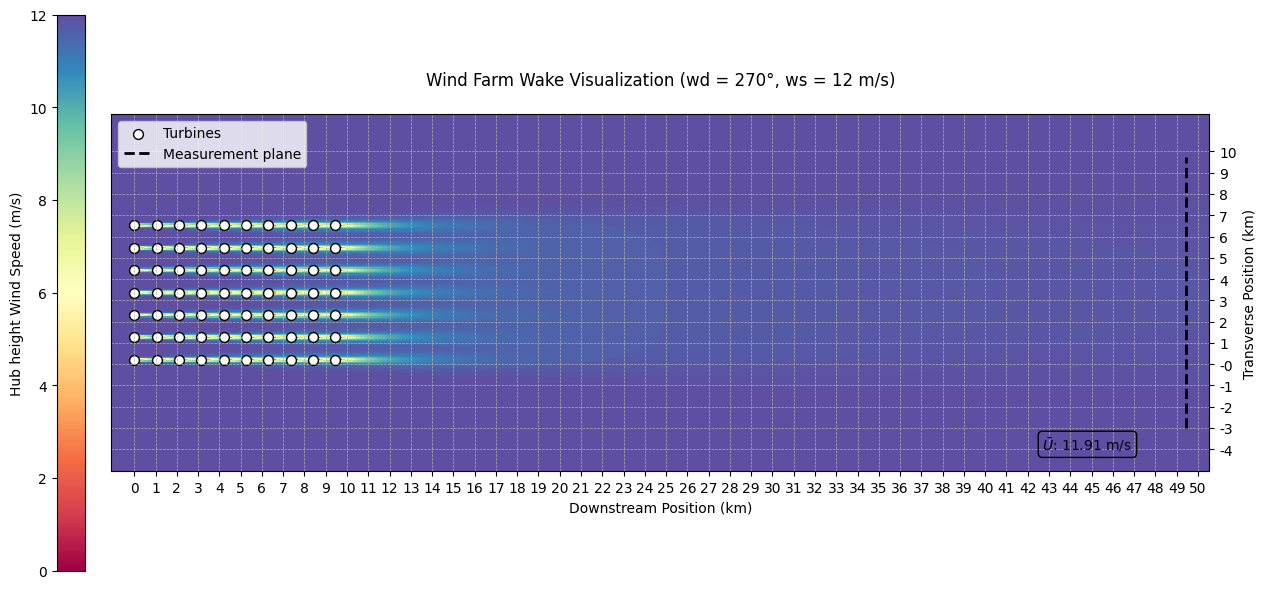

In [57]:
# --- Wake Visualization ---
fig, ax = plt.subplots(figsize=(14, 6))

# Compute the flow map and grid
flow_map_grid = HorizontalGrid(x=np.linspace(min(x)-1000, max(x)+(km_behind+1)*1000, 300), y=np.linspace(min(y)-1000-ext, max(y)+1000+ext, 300))
flow_map = sim.flow_map(grid=flow_map_grid)
wake_map = flow_map.sel(wd=wd, ws=ws, method="nearest")
vmin, vmax = 0, 12

wake_map.WS_eff.plot(ax=ax, cmap="Spectral", vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'Hub height Wind Speed (m/s)', 'location': 'left', "pad": 0.02})

# Plot turbine positions
ax.scatter(x, y, color="white", marker="o", s=50, label="Turbines", edgecolor="black", linewidth=1)
ax.vlines(x=x_meas, ymin=min(y_wake), ymax=max(y_wake), color='black', linestyle='--', linewidth=2, label="Measurement plane")
ax.set_title("\nWind Farm Wake Visualization (wd = " + str(wd) + "°, ws = " + str(ws) + " m/s)\n")
ax.set_xlabel("Downstream Position (km)")
ax.set_ylabel("Transverse Position (km)")
ax.set_aspect('equal')
ax.legend(loc='upper left')
plt.text(0.93, 0.1, r'$\bar{U}$: ' + f'{ws_avg_meas:.2f} m/s', ha='right', va='top', transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='none', alpha=1))

# Add axis labels, grid with ticklines
xticks = np.arange(min(x), max(x)+(km_behind+1)*1000, 1000)
yticks = np.arange(min(y)-ext, max(y)+ext, 1000)

ax.set_xticks(xticks)
ax.set_xticklabels([f"{val/1000:.0f}" for val in xticks])  # Convert to km
ax.set_yticks(yticks)
ax.set_yticklabels([f"{val/1000:.0f}" for val in yticks])  # Convert to km

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.tight_layout()

11.858566898422556


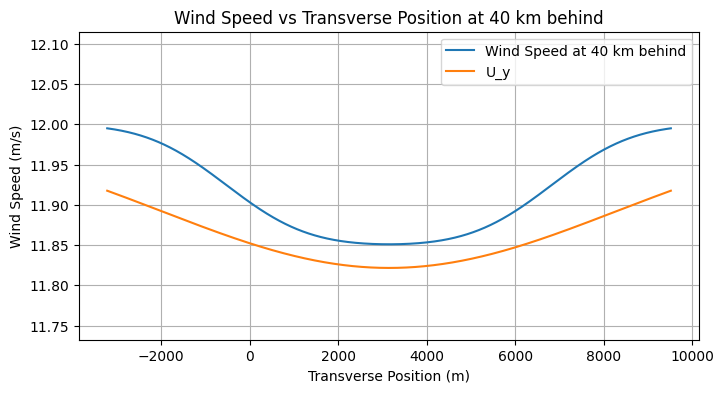

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(y_wake, ws_wake, label=f'Wind Speed at {km_behind} km behind')

'''
mu = max(y) / 2
sigma = D/2*((w_wake-max(y))/2 / max(y)) * x_meas/1000
print(sigma)

gk = ws - (sigma/2 * (1 / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(y_meas - mu)**2 / (2 * sigma**2))))
plt.plot(y_meas, gk, label='Fitted Gaussian kernel')
'''

k = 0.04

sigma = max(y)/2 + k*x_meas

U_max_def = ((ws - 11.82) * w_wake) / (np.sqrt(2*np.pi)*sigma)

U_y = U_max_def * np.exp(-(y_wake - np.median(y_wake))**2 / (2*sigma**2))

print(np.mean(ws-U_y))

plt.plot(y_wake, ws-U_y, label='U_y')

plt.xlabel('Transverse Position (m)')
plt.ylabel('Wind Speed (m/s)')

plt.ylim(0.99*min(ws_wake), 1.01*max(ws_wake))
plt.title(f'Wind Speed vs Transverse Position at {km_behind} km behind')
plt.legend()
plt.grid(True)
plt.show()